# Notes for FCN8

## Some Pytorch Code for Quick Understanding
- https://github.com/wkentaro/pytorch-fcn
- https://github.com/bodokaiser/piwise

In [1]:
import tensorflow as tf
from tensorflow.contrib import layers
import numpy as np

## load vgg16

In [2]:
# create a session
sess = tf.Session()

In [3]:

# load the frozen model
tf.saved_model.loader.load(sess, ["vgg16"], "data/vgg/")
# check the graph
graph = sess.graph

INFO:tensorflow:Restoring parameters from b'data/vgg/variables/variables'


In [4]:
# key variables
vgg_names = ["image_input", "keep_prob", "layer3_out", "layer4_out", "layer7_out"]
vgg16 = {name: graph.get_tensor_by_name("%s:0" % name) for name in vgg_names}

In [5]:
for name, tensor in vgg16.items():
    print(name, tensor.get_shape())

image_input (?, ?, ?, 3)
keep_prob <unknown>
layer3_out (?, ?, ?, 256)
layer4_out (?, ?, ?, 512)
layer7_out (?, ?, ?, 4096)


In [2]:
def load_vgg16(sess, model_path):
    tf.saved_model.loader.load(sess, ["vgg16"], "data/vgg/")
    graph = sess.graph
    vgg_names = ["image_input", "keep_prob", "layer3_out", "layer4_out", "layer7_out"]
    vgg16 = {name: graph.get_tensor_by_name("%s:0" % name) for name in vgg_names}
    return vgg16

## build fcn8

In [3]:
def build_fcn8(graph, vgg16, num_classes):
    model = vgg16.copy()
    with graph.as_default():
        weight_initializer = layers.variance_scaling_initializer()

        # fcn layers
        model["layer3_fcn"] = tf.layers.conv2d(model["layer3_out"], num_classes,
                                               kernel_size=(1, 1), strides=(1, 1),
                                               kernel_initializer=weight_initializer,
                                               name="layer3_fcn", padding="SAME")
        model["layer4_fcn"] = tf.layers.conv2d(model["layer4_out"], num_classes,
                                               kernel_size=(1, 1), strides=(1, 1),
                                               kernel_initializer=weight_initializer,
                                               name="layer4_fcn", padding="SAME")
        model["layer7_fcn"] = tf.layers.conv2d(model["layer7_out"], num_classes,
                                               kernel_size=(1, 1), strides=(1, 1),
                                               kernel_initializer=weight_initializer,
                                               name="layer7_fcn", padding="SAME")
        # upsampling and skipping - bottom up
        model["layer7_up"] = tf.layers.conv2d_transpose(model["layer7_fcn"], num_classes,
                                                        kernel_size=(4, 4), strides=(2, 2),
                                                        kernel_initializer=weight_initializer,
                                                        name="layer7_up", padding="SAME")
        model["layer4_skip"] = tf.add(model["layer4_fcn"], model["layer7_up"], name="layer4_skip")
        model["layer4_up"] = tf.layers.conv2d_transpose(model["layer4_skip"], num_classes,
                                                        kernel_size=(4, 4), strides=(2, 2),
                                                        kernel_initializer=weight_initializer,
                                                        name="layer4_up", padding="SAME")
        model["layer3_skip"] = tf.add(model["layer3_fcn"], model["layer4_up"], name="layer3_skip")
        model["heatmap"] = tf.layers.conv2d_transpose(model["layer3_skip"], num_classes,
                                                        kernel_size=(16, 16), strides=(8, 8),
                                                        kernel_initializer=weight_initializer,
                                                        name="layer3_up", padding="SAME")
        return model

In [8]:
fcn8 = build_fcn8(graph, vgg16, 2)

In [9]:
for name, tensor in fcn8.items():
    print(name, tensor.get_shape())

image_input (?, ?, ?, 3)
keep_prob <unknown>
layer3_out (?, ?, ?, 256)
layer4_out (?, ?, ?, 512)
layer7_out (?, ?, ?, 4096)
layer3_fcn (?, ?, ?, 2)
layer4_fcn (?, ?, ?, 2)
layer7_fcn (?, ?, ?, 2)
layer7_up (?, ?, ?, 2)
layer4_skip (?, ?, ?, 2)
layer4_up (?, ?, ?, 2)
layer3_skip (?, ?, ?, 2)
heatmap (?, ?, ?, 2)


## test fcn8

In [19]:
x = np.random.rand(16, 96, 288, 3)

In [20]:
sess.run(tf.global_variables_initializer())
names = fcn8.keys()
outputs = sess.run([fcn8[n] for n in names], feed_dict={
                            fcn8["image_input"]: x,
                            fcn8["keep_prob"]: 1})

In [21]:
for name, output in zip(names, outputs):
    print(name, output.shape)

image_input (16, 96, 288, 3)
keep_prob ()
layer3_out (16, 12, 36, 256)
layer4_out (16, 6, 18, 512)
layer7_out (16, 3, 9, 4096)
layer3_fcn (16, 12, 36, 2)
layer4_fcn (16, 6, 18, 2)
layer7_fcn (16, 3, 9, 2)
layer7_up (16, 6, 18, 2)
layer4_skip (16, 6, 18, 2)
layer4_up (16, 12, 36, 2)
layer3_skip (16, 12, 36, 2)
heatmap (16, 96, 288, 2)


In [22]:
sess.close()

## objective and training op

In [4]:
def train_fcn8(fcn8, targets, num_classes, lr):
    logits = tf.reshape(fcn8["heatmap"], [-1, num_classes])
    labels = tf.reshape(targets, [-1, num_classes])
    
    entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
    loss = tf.reduce_mean(entropy)
    
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    return logits, loss, train_op

## train fcn8

In [5]:
from helper import gen_batch_function

batch_size = 1
train_batches = gen_batch_function("data/data_road/training/", image_shape=(160, 576))

In [6]:
sess = tf.Session()
# tf.reset_default_graph()
vgg16 = load_vgg16(sess, "data/vgg/")
fcn8 = build_fcn8(sess.graph, vgg16, num_classes=2)

targets = tf.placeholder(tf.float32, shape=[None, None, None, 2], name="targets")
learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
logits, loss, train_op = train_fcn8(fcn8, targets, num_classes=2, lr=learning_rate)

sess.run(tf.global_variables_initializer())

INFO:tensorflow:Restoring parameters from b'data/vgg/variables/variables'


In [ ]:
n_epochs = 5



for epoch in range(n_epochs):
    for b, (images, gt_images) in enumerate(train_batches(batch_size)):
        _, loss_val = sess.run([train_op, loss],
                               feed_dict={
                                   fcn8["image_input"]: images,
                                   targets: gt_images,
                                   fcn8["keep_prob"]: 0.5,
                                   learning_rate: 5e-4
                               })
        if b % 10 == 0:
            print(epoch, b, loss_val)

In [17]:
sess.close()

## data augumentation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import helper
import os
image_shape = (32, 128)
data_dir = "./data/"
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

In [7]:
for b, (imgs, gt_imgs) in enumerate(get_batches_fn(2)):
    assert imgs.shape[1:]==(32, 128, 3), imgs.shape

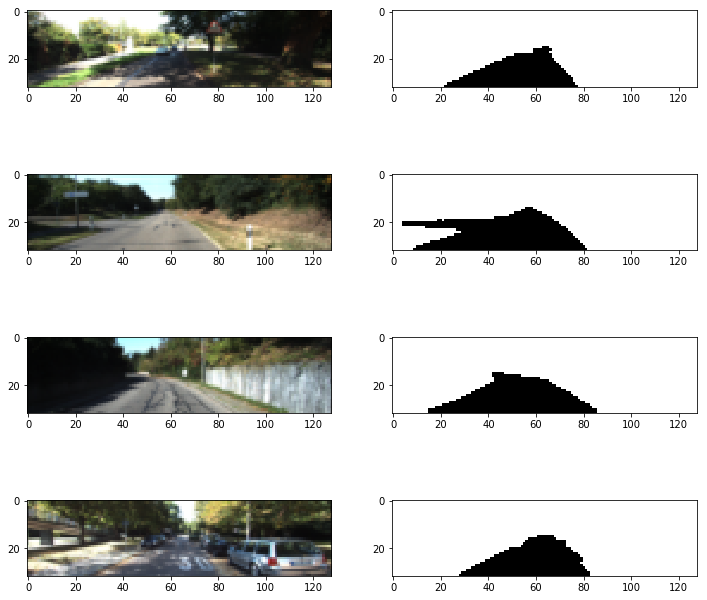

In [16]:
for imgs, gt_imgs in get_batches_fn(4):
    fig, axes = plt.subplots(4, 2, figsize=(2*6, 4*3))
    fig.subplots_adjust(wspace=0.2, hspace=0.)
    for i, img in enumerate(imgs):
        axes[i, 0].imshow(img)
    for i, gt_img in enumerate(gt_imgs):
        axes[i, 1].imshow(gt_img[:,:,0], cmap=plt.cm.gray)
    break

### translation

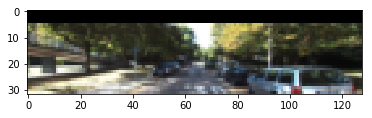

In [26]:
shifted_img = np.pad(img[:-5, ...], [(5, 0), (0, 0), (0, 0)], mode="constant", constant_values=0)
plt.imshow(shifted_img)

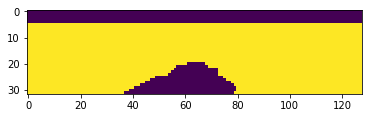

In [27]:
shifted_gt_img = np.pad(gt_img[:-5, ...], [(5, 0), (0, 0), (0, 0)], mode="constant", constant_values=0)
plt.imshow(shifted_gt_img[:,:,0])

### flipping

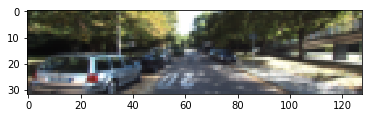

In [29]:
flipped_img = img[:,::-1, ...]
plt.imshow(flipped_img)

In [37]:
def augment_data(images, gt_images):
    # flipping horizontally
    hf_images = images[:, :, ::-1, ...]
    hf_gt_images = gt_images[:, :, ::-1, ...]
    aug_images = np.concatenate([images, hf_images], axis=0)
    aug_gt_images = np.concatenate([gt_images, hf_gt_images], axis=0)
    return aug_images, aug_gt_images

In [38]:
aug_images, aug_gt_images = augment_data(imgs, gt_imgs)

In [39]:
print(imgs.shape, gt_imgs.shape)
print(aug_images.shape, aug_gt_images.shape)

(4, 32, 128, 3) (4, 32, 128, 2)
(8, 32, 128, 3) (8, 32, 128, 2)


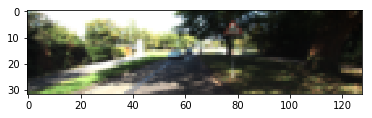

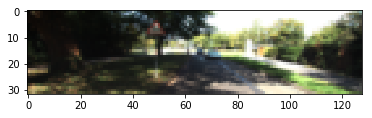

In [41]:
plt.imshow(aug_images[0])
plt.figure()
plt.imshow(aug_images[4])

In [43]:
for b, (imgs, gt_imgs) in enumerate(get_batches_fn(4)):
    imgs = imgs[:,:,::-1,:]
    gt_imgs = gt_imgs[:,:,::-1,:]
    break

In [44]:
imgs.ndim

4